In [55]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# Read from files and preprocess

In [83]:
GCS_PATTERN = "gs://flowers-public/*/*.jpg"
filenames = tf.io.gfile.glob(GCS_PATTERN)

num_images = len(filenames)
num_images

3670

In [6]:
filenames_ds = tf.data.Dataset.list_files(GCS_PATTERN)

2022-05-22 06:13:11.620596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-22 06:13:11.620617: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-22 06:13:11.620633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calcifer-Inspiron-7370): /proc/driver/nvidia/version does not exist
2022-05-22 06:13:11.620858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [74]:
for fn in filenames_ds.take(5):
    print(fn.numpy())

b'gs://flowers-public/roses/6676529655_9672b6f955_m.jpg'
b'gs://flowers-public/dandelion/8969938579_4c2032dd96_n.jpg'
b'gs://flowers-public/daisy/8694909523_3ca25d449d_n.jpg'
b'gs://flowers-public/roses/7187035716_5d0fb95c31_n.jpg'
b'gs://flowers-public/daisy/6864242336_0d12713fe5_n.jpg'


In [29]:
def decode_jpeg_and_label(filename):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(
        tf.expand_dims(filename, axis=-1),
        sep="/"
    ).values[-2]
    return image, label

In [30]:
ds = filenames_ds.map(decode_jpeg_and_label)

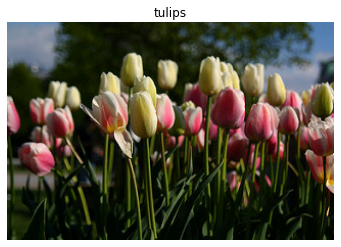

In [32]:
%matplotlib inline

sample_img, sample_label = ds.take(1).as_numpy_iterator().next()
plt.imshow(sample_img)
plt.axis("off")
plt.title(sample_label.decode("utf-8"))
plt.show()

In [63]:
def get_label(fn):
    return tf.strings.split(
        tf.expand_dims(filename, axis=-1),
        sep="/"
    ).values[-2]

In [91]:
class_names = np.unique([
    fn.numpy().decode("utf-8").split("/")[-2]
    for fn in filenames_ds]
)

class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [104]:
def one_hot(img, lbl):
    matches = tf.stack(
        [tf.equal(label, s) for s in class_names],
        axis=-1
    )
    one_hot = tf.cast(matches, tf.float32)
    new_label = tf.math.argmax(one_hot)
    return img, new_label

In [108]:
for img, lbl in ds.map(one_hot).take(1):
    print(lbl)

tf.Tensor(4, shape=(), dtype=int64)


# Read TFRecords

In [111]:
piece1 = 'gs://flowers-public/'
piece2 = 'tfrecords-jpeg-192x192-2/*.tfrec'
TFR_GCS_PATTERN = piece1 + piece2
tfr_filenames = tf.io.gfile.glob(TFR_GCS_PATTERN)

In [114]:
filenames_tfrds = tf.data.Dataset.list_files(TFR_GCS_PATTERN)

In [118]:
IMAGE_SIZE = [192, 192]
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
SHUFFLE_SIZE = 100
EPOCHS = 5

VALIDATION_SPLIT = 0.2
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [119]:
split = int(len(tfr_filenames) * VALIDATION_SPLIT)
training_filenames = tfr_filenames[split:]
validation_filenames = tfr_filenames[:split]

In [122]:
def read_tfrecord(example):
    features = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'class': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    class_label = example['class']
    return image, class_label

In [123]:
def load_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [124]:
def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache()
    if train:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(SHUFFLE_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [125]:
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)
training_dataset, validation_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)